In [1]:
import os
import argparse
import functools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.autograd as torch_ad
from tqdm.auto import tqdm, trange
from torch.utils.data import DataLoader

import firedrake as fd
from firedrake_adjoint import *
from firedrake.ml.pytorch import torch_operator

from physics_driven_ml.models import CNN
from physics_driven_ml.dataset_processing import PDEDataset, BatchedElement
from physics_driven_ml.utils import ModelConfig, get_logger
from physics_driven_ml.evaluation import evaluate


/Users/mh522/firedrake/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
import os
import torch
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import optim

def train(model, config, train_dl: DataLoader, dev_dl: DataLoader):
    """Train the model on a given dataset."""

    # Plot setup
    # plt.ion()
    # fig, ax = plt.subplots()
    # losses = []
    losses_ml = []
    
    errors = []
    
    optimiser = optim.AdamW(model.parameters(), lr=config.learning_rate, eps=1e-8)
    criterion = torch.nn.MSELoss()
    
    max_grad_norm = 1.0
    best_error = float('inf')

    # Training loop
    for epoch_num in trange(config.epochs):
        model.train()
        total_loss_ml = 0.0
        
        for batch in tqdm(train_dl):
            # Prepare the batch
            batch = BatchedElement(*[x.to(config.device, non_blocking=True) if isinstance(x, torch.Tensor) else x for x in batch])
            strain_input = batch.target.float()
            u_real = batch.u_real.float()
            #print('stress_real.shape ', u_real.shape)
            #print('stress_real elements ', u_real[:, :])
            # Zero the gradients
            model.zero_grad()
            
            # Forward pass
            stress_cnn = model(strain_input)
            #print('stress_cnn.shape ', stress_cnn.shape)
            #print('stress_cnn elements ', stress_cnn[:, :])
            
            # Compute loss
            loss_ml = criterion(stress_cnn, u_real)
            total_loss_ml += loss_ml.item()
            
            # Backpropagation
            loss_ml.backward()
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            optimiser.step()

        # Compute average losses
        average_epoch_loss_ml = total_loss_ml / len(train_dl)
        print(f"Epoch {epoch_num + 1} ML loss: {average_epoch_loss_ml:.4f}")
        
        losses_ml.append(average_epoch_loss_ml)
        
        # Evaluate on dev set
        error = evaluate(model, config, dev_dl, disable_tqdm=True)
        print(f"Error ({config.evaluation_metric}): {error}")
        errors.append(error)
        
        # Save best model
        if error < best_error:
            best_error = error
            model_dir = os.path.join(config.data_dir, "saved_models", config.model_dir)
            os.makedirs(model_dir, exist_ok=True)
            model_to_save = model.module if hasattr(model, "module") else model
            torch.save(model_to_save.state_dict(), os.path.join(model_dir, "model.pt"))
            config.to_file(filename=os.path.join(model_dir, "training_args.json"))

        # Update plots
        # plt.plot(losses_ml, label='Machine Learning Loss', color='red')
        # plt.legend()
        # plt.pause(0.001)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    # Update plots
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Machine Learning Loss', color='red')
    ax1.plot(losses_ml, label='Machine Learning Loss', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    
    ax2.set_ylabel('Error', color='blue')
    ax2.plot(errors, label='Error', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # plt.ioff()
    plt.show()

    return model


In [3]:
train_dataset = PDEDataset(dataset="solvepde", dataset_split="train", data_dir="data")
train_dataloader = DataLoader(train_dataset, batch_size=1, collate_fn=train_dataset.collate, shuffle=False)

test_dataset = PDEDataset(dataset="solvepde", dataset_split="test", data_dir="data")
test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=test_dataset.collate, shuffle=False)

## visualize sample in train/test set
stress_obs as input

strain as output

stress for validate

In [4]:
batch = next(iter(train_dataloader))
batch = BatchedElement(*[x.to("cpu", non_blocking=True) if isinstance(x, torch.Tensor) else x for x in batch])
strain = batch.target.to(torch.float32)
stress_real = batch.u_real
stress_obs = batch.u_obs
print('strain.shape ', strain.shape)
print('strain elements ', strain[:, :])

print('stress_real.shape ', stress_real.shape)
print('stress_real elements ', stress_real[:, :])

strain.shape  torch.Size([1, 4356])
strain elements  tensor([[-0.5780,  0.4579,  0.4579,  ...,  1.2895,  1.2895, -2.0493]])
stress_real.shape  torch.Size([1, 4356])
stress_real elements  tensor([[-1.5917, -0.1168, -0.6705,  ...,  1.1087,  1.8566,  2.1057]],
       dtype=torch.float64)


In [5]:

# Given tensor field data, create scalar functions for the components and magnitude
def create_scalar_functions_from_tensor(tensor_field, mesh):
    components = [(0, 0), (0, 1), (1, 0), (1, 1)]
    scalar_functions = []

    for (i, j) in components:
        scalar_data = tensor_field.dat.data[:, i, j]
        scalar_function = fd.Function(fd.FunctionSpace(mesh, "CG", 1))
        scalar_function.dat.data[:] = scalar_data
        scalar_functions.append(scalar_function)

    magnitude_data = np.sqrt(np.sum(tensor_field.dat.data**2, axis=(1, 2)))
    magnitude_function = fd.Function(fd.FunctionSpace(mesh, "CG", 1))
    magnitude_function.dat.data[:] = magnitude_data

    return scalar_functions, magnitude_function

# Visualize the scalar functions
def visualize_scalar_functions(scalar_functions, magnitude_function):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    titles = ["(0,0) Component", "(0,1) Component", "(1,0) Component", "(1,1) Component"]

    for ax, scalar_fn, title in zip(axs.ravel(), scalar_functions, titles):
        collection = fd.tripcolor(scalar_fn, axes=ax, cmap='coolwarm')
        ax.set_title(title)
        fig.colorbar(collection, ax=ax)

    plt.tight_layout()
    plt.show()

    # Visualize the magnitude
    plt.figure(figsize=(6, 5))
    collection = fd.tripcolor(magnitude_function, cmap='viridis')
    plt.colorbar(collection)
    plt.title("Tensor Magnitude (Frobenius Norm)")
    plt.show()
    
def visualize(dataloader, index):
    # Extract strain tensor from the test dataloader at the given index
    strain_tensor = dataloader.dataset[index].target
    mesh = fd.UnitSquareMesh(32, 32)
    # Convert to TensorFunctionSpace for visualization
    V_tensor = fd.TensorFunctionSpace(mesh, 'CG', 1)
    strain_function = fd.Function(V_tensor)
    strain_tensor = strain_tensor.reshape(-1, 2, 2)
    strain_function.dat.data[:] = strain_tensor.numpy()
    
    # Visualize the strain tensor fields
    scalar_fns, magnitude_fn = create_scalar_functions_from_tensor(strain_function, mesh)
    print("Visualizing Input Strain Tensor Fields")
    visualize_scalar_functions(scalar_fns, magnitude_fn)
    
    
    # Visualize real stress for comparison
    real_stress_tensor = dataloader.dataset[index].u_real
    real_stress_function = fd.Function(V_tensor)
    real_stress_tensor = real_stress_tensor.reshape(-1, 2, 2)
    print('real stress tensor ',real_stress_tensor.shape)
    real_stress_function.dat.data[:] = real_stress_tensor.numpy()
    
    scalar_fns_real, magnitude_fn_real = create_scalar_functions_from_tensor(real_stress_function, mesh)
    print("Visualizing Real Stress Tensor Fields")
    visualize_scalar_functions(scalar_fns_real, magnitude_fn_real)


Visualizing Input Strain Tensor Fields


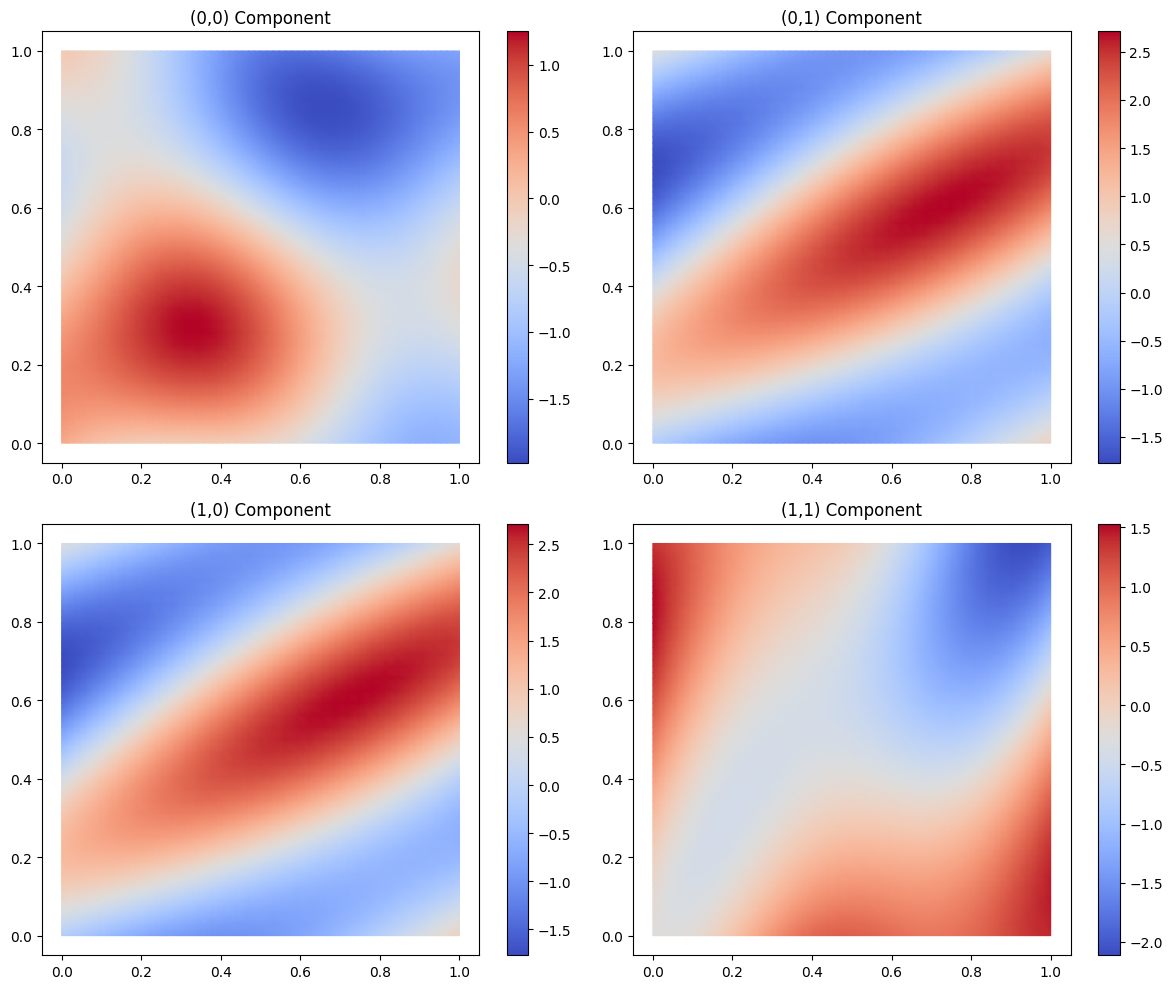

<Figure size 600x500 with 0 Axes>

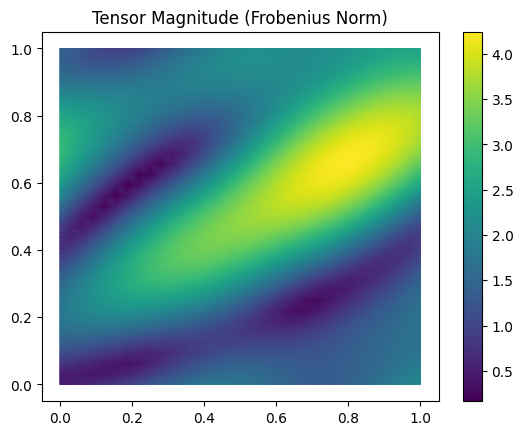

real stress tensor  torch.Size([1089, 2, 2])
Visualizing Real Stress Tensor Fields


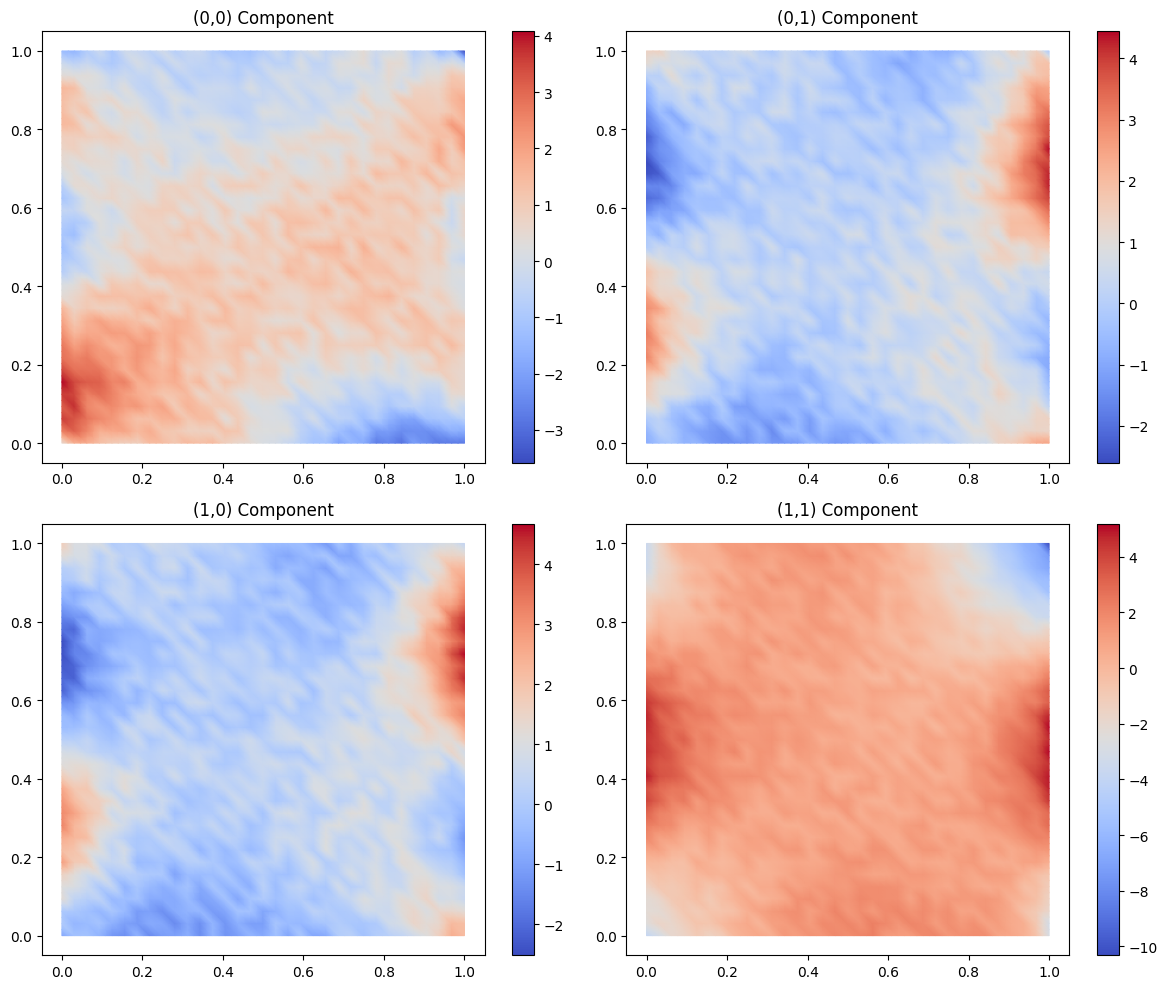

<Figure size 600x500 with 0 Axes>

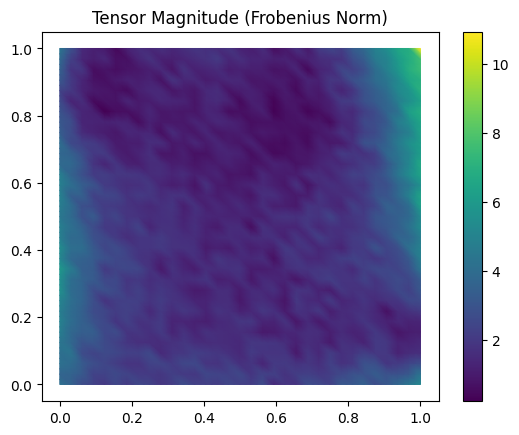

In [6]:
train_dataset = PDEDataset(dataset="solvepde", dataset_split="train", data_dir="data")
train_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=test_dataset.collate, shuffle=False)

# Test the predict function
visualize(train_dataloader, index=0)  # Example with index 0

100%|██████████| 50/50 [00:04<00:00, 12.28it/s]


Epoch 1 ML loss: 1.3391


100%|██████████| 50/50 [00:00<00:00, 143.87it/s]


Error (L2): 1.2600942611694337


100%|██████████| 50/50 [00:04<00:00, 11.99it/s]


Epoch 2 ML loss: 1.2421


  2%|▏         | 2/100 [00:09<07:33,  4.63s/it]

Error (L2): 1.8855205273628235


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


Epoch 3 ML loss: 1.2337


  3%|▎         | 3/100 [00:13<06:54,  4.27s/it]

Error (L2): 2.0438695776462557


100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


Epoch 4 ML loss: 1.2322


  4%|▍         | 4/100 [00:16<06:28,  4.05s/it]

Error (L2): 1.605574413537979


100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


Epoch 5 ML loss: 1.1593


  5%|▌         | 5/100 [00:20<06:14,  3.95s/it]

Error (L2): 1.4901069569587708


100%|██████████| 50/50 [00:03<00:00, 14.22it/s]


Epoch 6 ML loss: 1.2013


  6%|▌         | 6/100 [00:24<06:04,  3.88s/it]

Error (L2): 1.2643933808803558


100%|██████████| 50/50 [00:03<00:00, 14.94it/s]


Epoch 7 ML loss: 1.1388


  7%|▋         | 7/100 [00:28<05:52,  3.79s/it]

Error (L2): 1.6749520373344422


100%|██████████| 50/50 [00:03<00:00, 14.85it/s]


Epoch 8 ML loss: 1.0912


  8%|▊         | 8/100 [00:31<05:42,  3.72s/it]

Error (L2): 1.7297878217697145


100%|██████████| 50/50 [00:03<00:00, 14.35it/s]


Epoch 9 ML loss: 1.0849


  9%|▉         | 9/100 [00:35<05:38,  3.72s/it]

Error (L2): 1.8345795810222625


100%|██████████| 50/50 [00:03<00:00, 14.36it/s]


Epoch 10 ML loss: 1.0579


 10%|█         | 10/100 [00:39<05:34,  3.72s/it]

Error (L2): 1.4943422019481658


100%|██████████| 50/50 [00:03<00:00, 14.75it/s]


Epoch 11 ML loss: 1.0392


 11%|█         | 11/100 [00:42<05:28,  3.69s/it]

Error (L2): 1.2943880760669708


100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


Epoch 12 ML loss: 1.0181


 12%|█▏        | 12/100 [00:46<05:25,  3.69s/it]

Error (L2): 1.7767643928527832


100%|██████████| 50/50 [00:03<00:00, 14.64it/s]


Epoch 13 ML loss: 0.9647


 13%|█▎        | 13/100 [00:49<05:20,  3.68s/it]

Error (L2): 1.5756863522529603


100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


Epoch 14 ML loss: 0.9176


 14%|█▍        | 14/100 [00:53<05:13,  3.64s/it]

Error (L2): 1.9244508826732636


100%|██████████| 50/50 [00:03<00:00, 14.84it/s]


Epoch 15 ML loss: 0.9125


 15%|█▌        | 15/100 [00:57<05:08,  3.63s/it]

Error (L2): 1.4855651199817657


100%|██████████| 50/50 [00:03<00:00, 14.68it/s]


Epoch 16 ML loss: 0.9095


 16%|█▌        | 16/100 [01:00<05:07,  3.66s/it]

Error (L2): 1.576829731464386


100%|██████████| 50/50 [00:03<00:00, 13.72it/s]


Epoch 17 ML loss: 0.8843


 17%|█▋        | 17/100 [01:04<05:09,  3.73s/it]

Error (L2): 1.7386907875537871


100%|██████████| 50/50 [00:03<00:00, 14.44it/s]


Epoch 18 ML loss: 0.8592


 18%|█▊        | 18/100 [01:08<05:04,  3.72s/it]

Error (L2): 1.3266326665878296


100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


Epoch 19 ML loss: 0.8483


 19%|█▉        | 19/100 [01:12<04:57,  3.67s/it]

Error (L2): 1.4923710536956787


100%|██████████| 50/50 [00:03<00:00, 14.66it/s]


Epoch 20 ML loss: 0.8364


 20%|██        | 20/100 [01:15<04:53,  3.66s/it]

Error (L2): 1.387045294046402


100%|██████████| 50/50 [00:03<00:00, 14.51it/s]


Epoch 21 ML loss: 0.8075


100%|██████████| 50/50 [00:00<00:00, 222.35it/s]


Error (L2): 1.2269974541664124


100%|██████████| 50/50 [00:03<00:00, 14.36it/s]]


Epoch 22 ML loss: 0.7914


 22%|██▏       | 22/100 [01:23<04:51,  3.74s/it]

Error (L2): 1.2366621363162995


100%|██████████| 50/50 [00:03<00:00, 14.19it/s]


Epoch 23 ML loss: 0.7848


 23%|██▎       | 23/100 [01:27<04:48,  3.74s/it]

Error (L2): 1.9679401409626007


100%|██████████| 50/50 [00:03<00:00, 14.23it/s]


Epoch 24 ML loss: 0.7849


100%|██████████| 50/50 [00:00<00:00, 193.04it/s]


Error (L2): 1.1409085834026336


100%|██████████| 50/50 [00:03<00:00, 13.25it/s]]


Epoch 25 ML loss: 0.7731


 25%|██▌       | 25/100 [01:35<04:54,  3.93s/it]

Error (L2): 1.4313858270645141


100%|██████████| 50/50 [00:03<00:00, 13.71it/s]


Epoch 26 ML loss: 0.7392


 26%|██▌       | 26/100 [01:39<04:50,  3.92s/it]

Error (L2): 1.434006428718567


100%|██████████| 50/50 [00:03<00:00, 15.21it/s]


Epoch 27 ML loss: 0.7350


 27%|██▋       | 27/100 [01:42<04:37,  3.80s/it]

Error (L2): 1.4448390901088715


100%|██████████| 50/50 [00:03<00:00, 15.19it/s]


Epoch 28 ML loss: 0.7342


 28%|██▊       | 28/100 [01:46<04:27,  3.72s/it]

Error (L2): 1.5319930243492126


100%|██████████| 50/50 [00:03<00:00, 15.06it/s]


Epoch 29 ML loss: 0.7150


 29%|██▉       | 29/100 [01:49<04:20,  3.67s/it]

Error (L2): 1.2870902729034424


100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


Epoch 30 ML loss: 0.6893


 30%|███       | 30/100 [01:53<04:14,  3.63s/it]

Error (L2): 1.4849479150772096


100%|██████████| 50/50 [00:03<00:00, 15.06it/s]


Epoch 31 ML loss: 0.6874


 31%|███       | 31/100 [01:56<04:09,  3.61s/it]

Error (L2): 1.4919919741153718


100%|██████████| 50/50 [00:03<00:00, 15.14it/s]


Epoch 32 ML loss: 0.6728


 32%|███▏      | 32/100 [02:00<04:04,  3.59s/it]

Error (L2): 2.0507107901573183


100%|██████████| 50/50 [00:03<00:00, 15.20it/s]


Epoch 33 ML loss: 0.6787


 33%|███▎      | 33/100 [02:03<03:59,  3.57s/it]

Error (L2): 1.717937844991684


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Epoch 34 ML loss: 0.6593


 34%|███▍      | 34/100 [02:07<03:55,  3.57s/it]

Error (L2): 1.4084368300437928


100%|██████████| 50/50 [00:03<00:00, 14.68it/s]


Epoch 35 ML loss: 0.6563


 35%|███▌      | 35/100 [02:11<03:53,  3.59s/it]

Error (L2): 1.6881685316562653


100%|██████████| 50/50 [00:03<00:00, 14.48it/s]


Epoch 36 ML loss: 0.6284


 36%|███▌      | 36/100 [02:14<03:51,  3.62s/it]

Error (L2): 1.5234460961818694


100%|██████████| 50/50 [00:03<00:00, 14.94it/s]


Epoch 37 ML loss: 0.6180


 37%|███▋      | 37/100 [02:18<03:47,  3.61s/it]

Error (L2): 1.2815141153335572


100%|██████████| 50/50 [00:03<00:00, 14.27it/s]


Epoch 38 ML loss: 0.6304


 38%|███▊      | 38/100 [02:22<03:46,  3.65s/it]

Error (L2): 1.3524539124965669


100%|██████████| 50/50 [00:03<00:00, 13.78it/s]


Epoch 39 ML loss: 0.6113


 39%|███▉      | 39/100 [02:26<03:46,  3.72s/it]

Error (L2): 1.3250623941421509


100%|██████████| 50/50 [00:03<00:00, 14.76it/s]


Epoch 40 ML loss: 0.5949


 40%|████      | 40/100 [02:29<03:41,  3.69s/it]

Error (L2): 1.514241737127304


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


Epoch 41 ML loss: 0.5888


 41%|████      | 41/100 [02:33<03:39,  3.72s/it]

Error (L2): 1.5282185578346252


100%|██████████| 50/50 [00:03<00:00, 13.98it/s]


Epoch 42 ML loss: 0.5618


 42%|████▏     | 42/100 [02:37<03:37,  3.75s/it]

Error (L2): 1.5732555437088012


100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


Epoch 43 ML loss: 0.5680


 43%|████▎     | 43/100 [02:41<03:32,  3.73s/it]

Error (L2): 1.469235372543335


100%|██████████| 50/50 [00:03<00:00, 14.48it/s]


Epoch 44 ML loss: 0.5457


 44%|████▍     | 44/100 [02:44<03:28,  3.72s/it]

Error (L2): 1.537414790391922


100%|██████████| 50/50 [00:03<00:00, 14.96it/s]


Epoch 45 ML loss: 0.5304


 45%|████▌     | 45/100 [02:48<03:22,  3.67s/it]

Error (L2): 1.4033172357082366


100%|██████████| 50/50 [00:03<00:00, 14.34it/s]


Epoch 46 ML loss: 0.5256


 46%|████▌     | 46/100 [02:52<03:18,  3.68s/it]

Error (L2): 1.661131911277771


100%|██████████| 50/50 [00:03<00:00, 14.60it/s]


Epoch 47 ML loss: 0.5113


 47%|████▋     | 47/100 [02:55<03:15,  3.68s/it]

Error (L2): 1.427335320711136


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


Epoch 48 ML loss: 0.4997


 48%|████▊     | 48/100 [02:59<03:09,  3.64s/it]

Error (L2): 1.4445685386657714


100%|██████████| 50/50 [00:03<00:00, 15.21it/s]


Epoch 49 ML loss: 0.4984


 49%|████▉     | 49/100 [03:02<03:03,  3.60s/it]

Error (L2): 1.5865632092952728


100%|██████████| 50/50 [00:03<00:00, 13.31it/s]


Epoch 50 ML loss: 0.4793


 50%|█████     | 50/100 [03:06<03:06,  3.72s/it]

Error (L2): 1.3016680431365968


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


Epoch 51 ML loss: 0.4805


 51%|█████     | 51/100 [03:10<03:03,  3.74s/it]

Error (L2): 1.733120355606079


100%|██████████| 50/50 [00:03<00:00, 14.98it/s]


Epoch 52 ML loss: 0.4760


 52%|█████▏    | 52/100 [03:14<02:57,  3.69s/it]

Error (L2): 1.66498836517334


100%|██████████| 50/50 [00:03<00:00, 15.03it/s]


Epoch 53 ML loss: 0.4696


 53%|█████▎    | 53/100 [03:17<02:51,  3.65s/it]

Error (L2): 1.5410702967643737


100%|██████████| 50/50 [00:03<00:00, 14.82it/s]


Epoch 54 ML loss: 0.4753


 54%|█████▍    | 54/100 [03:21<02:47,  3.63s/it]

Error (L2): 1.425852724313736


100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


Epoch 55 ML loss: 0.4812


 55%|█████▌    | 55/100 [03:24<02:42,  3.61s/it]

Error (L2): 1.4655213391780852


100%|██████████| 50/50 [00:03<00:00, 14.11it/s]


Epoch 56 ML loss: 0.4629


 56%|█████▌    | 56/100 [03:28<02:41,  3.67s/it]

Error (L2): 1.4851975214481354


100%|██████████| 50/50 [00:03<00:00, 14.44it/s]


Epoch 57 ML loss: 0.4628


 57%|█████▋    | 57/100 [03:32<02:38,  3.68s/it]

Error (L2): 1.6796257758140565


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


Epoch 58 ML loss: 0.4651


 58%|█████▊    | 58/100 [03:36<02:36,  3.73s/it]

Error (L2): 1.339955118894577


100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


Epoch 59 ML loss: 0.4555


 59%|█████▉    | 59/100 [03:39<02:33,  3.73s/it]

Error (L2): 1.5734919440746307


100%|██████████| 50/50 [00:03<00:00, 14.94it/s]


Epoch 60 ML loss: 0.4450


 60%|██████    | 60/100 [03:43<02:27,  3.70s/it]

Error (L2): 1.4777131700515747


100%|██████████| 50/50 [00:03<00:00, 15.15it/s]


Epoch 61 ML loss: 0.4392


 61%|██████    | 61/100 [03:47<02:22,  3.65s/it]

Error (L2): 1.3485367727279662


100%|██████████| 50/50 [00:03<00:00, 14.74it/s]


Epoch 62 ML loss: 0.4302


 62%|██████▏   | 62/100 [03:50<02:18,  3.64s/it]

Error (L2): 1.4758880269527435


100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


Epoch 63 ML loss: 0.4271


 63%|██████▎   | 63/100 [03:54<02:13,  3.62s/it]

Error (L2): 1.6055954968929291


100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


Epoch 64 ML loss: 0.4254


 64%|██████▍   | 64/100 [03:57<02:08,  3.58s/it]

Error (L2): 1.4949331271648407


100%|██████████| 50/50 [00:03<00:00, 15.51it/s]


Epoch 65 ML loss: 0.4235


 65%|██████▌   | 65/100 [04:01<02:03,  3.54s/it]

Error (L2): 1.460825561285019


100%|██████████| 50/50 [00:03<00:00, 15.61it/s]


Epoch 66 ML loss: 0.4164


 66%|██████▌   | 66/100 [04:04<01:59,  3.51s/it]

Error (L2): 1.4215691661834717


100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Epoch 67 ML loss: 0.4097


 67%|██████▋   | 67/100 [04:08<01:56,  3.52s/it]

Error (L2): 1.6026660847663878


100%|██████████| 50/50 [00:03<00:00, 15.54it/s]


Epoch 68 ML loss: 0.4038


 68%|██████▊   | 68/100 [04:11<01:51,  3.49s/it]

Error (L2): 1.5727182364463805


100%|██████████| 50/50 [00:03<00:00, 15.50it/s]


Epoch 69 ML loss: 0.4099


 69%|██████▉   | 69/100 [04:15<01:48,  3.48s/it]

Error (L2): 1.475245304107666


100%|██████████| 50/50 [00:03<00:00, 15.32it/s]


Epoch 70 ML loss: 0.4124


 70%|███████   | 70/100 [04:18<01:44,  3.49s/it]

Error (L2): 1.4884036660194397


100%|██████████| 50/50 [00:03<00:00, 15.33it/s]


Epoch 71 ML loss: 0.4080


 71%|███████   | 71/100 [04:22<01:41,  3.49s/it]

Error (L2): 1.3977662241458892


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


Epoch 72 ML loss: 0.4098


 72%|███████▏  | 72/100 [04:25<01:37,  3.49s/it]

Error (L2): 1.6037961328029633


100%|██████████| 50/50 [00:03<00:00, 15.30it/s]


Epoch 73 ML loss: 0.4037


 73%|███████▎  | 73/100 [04:29<01:34,  3.49s/it]

Error (L2): 1.4832686138153077


100%|██████████| 50/50 [00:03<00:00, 15.34it/s]


Epoch 74 ML loss: 0.3942


 74%|███████▍  | 74/100 [04:32<01:30,  3.49s/it]

Error (L2): 1.5643344080448152


100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Epoch 75 ML loss: 0.3922


 75%|███████▌  | 75/100 [04:36<01:27,  3.49s/it]

Error (L2): 1.4106515944004059


100%|██████████| 50/50 [00:03<00:00, 14.97it/s]


Epoch 76 ML loss: 0.3851


 76%|███████▌  | 76/100 [04:39<01:24,  3.51s/it]

Error (L2): 1.4530470442771912


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Epoch 77 ML loss: 0.3815


 77%|███████▋  | 77/100 [04:43<01:20,  3.50s/it]

Error (L2): 1.4957057380676269


100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


Epoch 78 ML loss: 0.3809


 78%|███████▊  | 78/100 [04:46<01:17,  3.51s/it]

Error (L2): 1.461251471042633


100%|██████████| 50/50 [00:03<00:00, 15.64it/s]


Epoch 79 ML loss: 0.3779


 79%|███████▉  | 79/100 [04:50<01:13,  3.48s/it]

Error (L2): 1.5091315817832947


100%|██████████| 50/50 [00:03<00:00, 14.51it/s]


Epoch 80 ML loss: 0.3772


 80%|████████  | 80/100 [04:53<01:11,  3.56s/it]

Error (L2): 1.4853381717205048


100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


Epoch 81 ML loss: 0.3789


 81%|████████  | 81/100 [04:57<01:08,  3.63s/it]

Error (L2): 1.535191340446472


100%|██████████| 50/50 [00:03<00:00, 14.24it/s]


Epoch 82 ML loss: 0.3841


 82%|████████▏ | 82/100 [05:01<01:06,  3.67s/it]

Error (L2): 1.383763121366501


100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


Epoch 83 ML loss: 0.3870


 83%|████████▎ | 83/100 [05:05<01:04,  3.78s/it]

Error (L2): 1.4842727077007294


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


Epoch 84 ML loss: 0.3834


 84%|████████▍ | 84/100 [05:09<01:00,  3.78s/it]

Error (L2): 1.4091713559627532


100%|██████████| 50/50 [00:03<00:00, 13.90it/s]


Epoch 85 ML loss: 0.3799


 85%|████████▌ | 85/100 [05:12<00:56,  3.80s/it]

Error (L2): 1.5520197212696076


100%|██████████| 50/50 [00:03<00:00, 13.33it/s]


Epoch 86 ML loss: 0.3811


 86%|████████▌ | 86/100 [05:16<00:54,  3.86s/it]

Error (L2): 1.5698519217967988


100%|██████████| 50/50 [00:03<00:00, 14.59it/s]


Epoch 87 ML loss: 0.3812


 87%|████████▋ | 87/100 [05:20<00:49,  3.81s/it]

Error (L2): 1.4250839030742646


100%|██████████| 50/50 [00:03<00:00, 14.48it/s]


Epoch 88 ML loss: 0.3895


 88%|████████▊ | 88/100 [05:24<00:45,  3.77s/it]

Error (L2): 1.5130611634254456


100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


Epoch 89 ML loss: 0.3916


 89%|████████▉ | 89/100 [05:27<00:41,  3.73s/it]

Error (L2): 1.5414134860038757


100%|██████████| 50/50 [00:03<00:00, 14.01it/s]


Epoch 90 ML loss: 0.3842


 90%|█████████ | 90/100 [05:31<00:37,  3.75s/it]

Error (L2): 1.420723116993904


100%|██████████| 50/50 [00:03<00:00, 14.06it/s]


Epoch 91 ML loss: 0.3779


 91%|█████████ | 91/100 [05:35<00:33,  3.77s/it]

Error (L2): 1.427557499408722


100%|██████████| 50/50 [00:03<00:00, 14.27it/s]


Epoch 92 ML loss: 0.3694


 92%|█████████▏| 92/100 [05:39<00:30,  3.76s/it]

Error (L2): 1.4817608308792114


100%|██████████| 50/50 [00:03<00:00, 13.46it/s]


Epoch 93 ML loss: 0.3639


 93%|█████████▎| 93/100 [05:43<00:26,  3.82s/it]

Error (L2): 1.4318989658355712


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


Epoch 94 ML loss: 0.3611


 94%|█████████▍| 94/100 [05:47<00:23,  3.85s/it]

Error (L2): 1.3990857768058778


100%|██████████| 50/50 [00:03<00:00, 14.12it/s]


Epoch 95 ML loss: 0.3604


 95%|█████████▌| 95/100 [05:50<00:19,  3.83s/it]

Error (L2): 1.3786053347587586


100%|██████████| 50/50 [00:03<00:00, 14.05it/s]


Epoch 96 ML loss: 0.3578


 96%|█████████▌| 96/100 [05:54<00:15,  3.82s/it]

Error (L2): 1.3630224359035492


100%|██████████| 50/50 [00:03<00:00, 14.68it/s]


Epoch 97 ML loss: 0.3599


 97%|█████████▋| 97/100 [05:58<00:11,  3.78s/it]

Error (L2): 1.4801160645484925


100%|██████████| 50/50 [00:03<00:00, 14.83it/s]


Epoch 98 ML loss: 0.3609


 98%|█████████▊| 98/100 [06:02<00:07,  3.74s/it]

Error (L2): 1.4099758350849152


100%|██████████| 50/50 [00:03<00:00, 13.89it/s]


Epoch 99 ML loss: 0.3639


 99%|█████████▉| 99/100 [06:05<00:03,  3.77s/it]

Error (L2): 1.6374531698226928


100%|██████████| 50/50 [00:03<00:00, 14.26it/s]


Epoch 100 ML loss: 0.3722


100%|██████████| 100/100 [06:09<00:00,  3.70s/it]


Error (L2): 1.3913622450828553


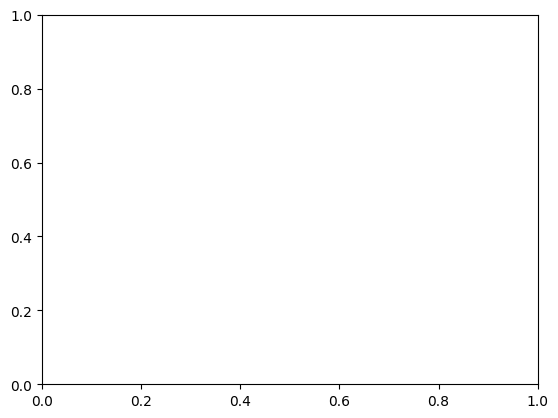

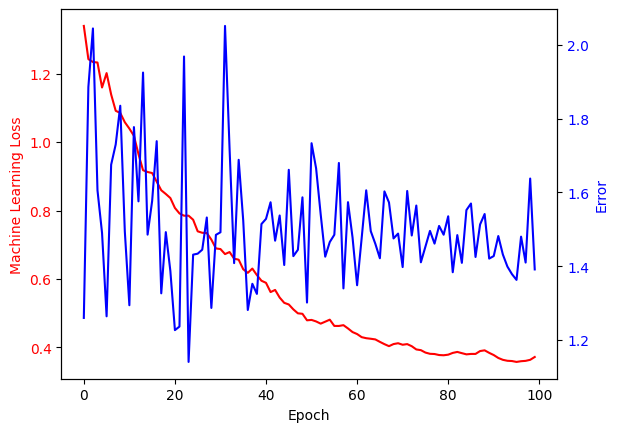

CNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (linear_encoder): Linear(in_features=4356, out_features=4356, bias=True)
  (hidden_e): Linear(in_features=4356, out_features=4356, bias=True)
  (hidden_d): Linear(in_features=4356, out_features=4356, bias=True)
  (linear_decoder): Linear(in_features=4356, out_features=1024, bias=True)
  (cnn_encoder): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e

In [7]:
mesh = train_dataset.mesh
V = fd.TensorFunctionSpace(mesh, "CG", 1)

config = ModelConfig()
config.model = "cnn"
config.input_shape = V.dim()
config.epochs = 100
config.model_dir = "solvepde"
config.dataset: str = "solvepde"
config.device = "cuda" if torch.cuda.is_available() else "cpu"
# batch = BatchedElement(*[x.to(config.device, non_blocking=True) if isinstance(x, torch.Tensor) else x for x in batch])
# k_exact = batch.target
# u_obs = batch.u_obs
train(CNN(config), config=config, train_dl=train_dataloader, dev_dl=test_dataloader)